## Importing Important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

#### Loading the data onto notebook.

In [3]:
data = pd.read_csv("../../Data/adult.csv")
data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


![](https://kiarofoods.com/wp-content/uploads/2019/10/line_break.png)
# Exploratory Data Analysis:
**Problem Type Identification:** We have the target variable available with us. So, it a supervised machine learning problem. First we try to find out the type of supervised machine learning that we have in this case study by lookin at the target variable

In [4]:
print(f"Target: 'Income'\nUnique Values in Income: {data.income.unique()}\nNumber of unique values: {data.income.nunique()}")

Target: 'Income'
Unique Values in Income: ['<=50K' '>50K']
Number of unique values: 2


In the problem, we have 'Income' as the Target variable. we see that we have only two values which are to be predicted, either the income is greater than 50K, which is Yes, or the income is less than or equal to 50K, which is No. We will label encode the target variable.

In [5]:
data['income'] = data['income'].str.replace('<=50K', '0')
data['income'] = data['income'].str.replace('>50K', '1')
data['income'] = data['income'].astype(np.int64)

In [6]:
data.income.dtypes

dtype('int64')

We can see that, we have encoded the values of the target variable, and converted it into int data-type. This problem is a classification problem with 'Income' as the target variable. Making a copy of the dataset to work ahead

In [7]:
ds = data.copy()
print(f"Unique values in 'education': {ds.education.nunique()}\nUnique values in 'Education_num': {ds['education.num'].nunique()}")

Unique values in 'education': 16
Unique values in 'Education_num': 16


We see that for the feature 'Education', we already have the encoded values in feature 'Education_num'. 'Education' will be removed from the dataset.

In [8]:
ds.drop(['education'], axis = 1, inplace = True)

Checking to see that is there any Null values present in the data that we have. Handling the null values will be the first thing that we need to do. Then, we have a look at the data-types of the other features and the value counts and unique values in those features.

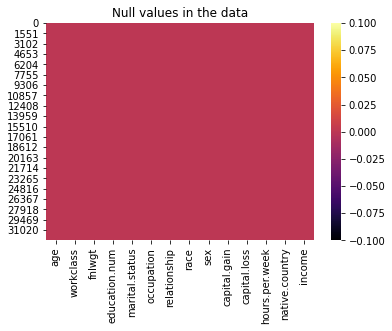

In [9]:
plt.title("Null values in the data", fontsize = 12)
sns.heatmap(ds.isnull(), cmap = 'inferno')
plt.show()

From the heatmap, we see that the dataset consists of no null values. But for some features, we have '?' as the values present. **'?' will be considered as null values.** We move ahead with the feature engineering part. Checking the datatypes of the columns

In [10]:
print("Datatype of every feature: ")
ds.dtypes

Datatype of every feature: 


age                int64
workclass         object
fnlwgt             int64
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income             int64
dtype: object

In [11]:
print("Number of unique values in every feature: ")
ds.nunique()

Number of unique values in every feature: 


age                  73
workclass             9
fnlwgt            21648
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

*'Workclass', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country' are the categorical variables in the data*. Proper encoding or conversion of these variables is necessary for the feature engineering. We will look at these attributes and convert them one by one.

**'Workclass':** Starting off with the work class, we look the number of unique values and value counts for those values

In [12]:
ds.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In work class, *majority of the people are private employees*. The *minority of people are either working without-pay or they have never-worked*. We can combine the values of these two values as one. first we remove the blank space from the column is present in any values.

In [13]:
ds['workclass'] = ds['workclass'].str.replace('Never-worked', 'Without-pay')

Now, we have 8 unique values in this feature. But, we see that **there are some values where we have '?' in the column. This values can be replaced with NaN values.**

In [14]:
ds['workclass'] = ds['workclass'].replace('?', np.NaN)

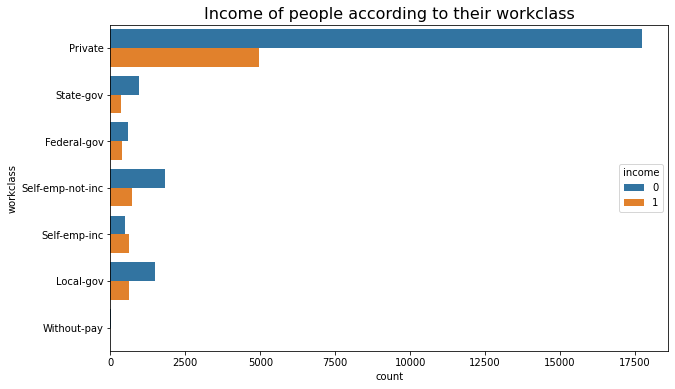

In [15]:
plt.figure(figsize = (10,6))
plt.title("Income of people according to their workclass", fontsize = 16)
sns.countplot(y = ds['workclass'], hue = ds['income'])
plt.show()

We see that the **majority of people who have income more than 50K a year are from private sector**. Same goes for the people with income less than 50K. But *for the Self Employed sector, the number of people whose income > 50K are more than the number of people whose income < 50K.* Now, moving ahead with replacing the null values and encoding the feature. **We will replace the NaN values in the 'Workclass' feature by the mode of the column, grouping it by the 'Occupation' feature.** We now have 7 unique values in Workclass feature. We can encode these values using the frequency encoding technique.

In [16]:
from scipy.stats import mode
workclass_mode = ds.pivot_table(values='workclass', columns='occupation',aggfunc=(lambda x:mode(x).mode[0]))
workclass_mode

occupation,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
workclass,Without-pay,Private,Federal-gov,Private,Private,Private,Private,Private,Private,Private,Private,Local-gov,Private,Private,Private


In [17]:
loc1 = ds['workclass'].isnull()
ds.loc[loc1, 'workclass'] = ds.loc[loc1,'occupation'].apply(lambda x: workclass_mode[x])

In [18]:
workclass_enc = (ds.groupby('workclass').size()) / len(ds)
print(workclass_enc)

ds['workclass_enc'] = ds['workclass'].apply(lambda x : workclass_enc[x])
ds['workclass_enc'].head(3)

workclass
Federal-gov         0.029483
Local-gov           0.064279
Private             0.697030
Self-emp-inc        0.034274
Self-emp-not-inc    0.078038
State-gov           0.039864
Without-pay         0.057031
dtype: float64


0    0.057031
1    0.697030
2    0.057031
Name: workclass_enc, dtype: float64

In [19]:
ds.drop(['workclass'], axis = 1, inplace = True)

**'Occupation':** Similar to 'Workclass', we will look at the unique values and value counts in the 'Occupation' feature.

In [20]:
ds.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

**We will drop the rows where the occupation is NaN.**

In [21]:
ds['occupation'] = ds['occupation'].replace('?', np.NaN)
ds = ds.loc[ds['occupation'].isnull() == False]
ds

,age,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_enc
1,82,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,0.69703
3,54,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,0.69703
4,41,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,0.69703
5,34,216864,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0,0.69703
6,38,150601,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0,0.69703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,310152,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0,0.69703
32557,27,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,0.69703
32558,40,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,0.69703
32559,58,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,0.69703


As we cannn see that after removing the null values from 'occupation', we are left with 30718 observations.

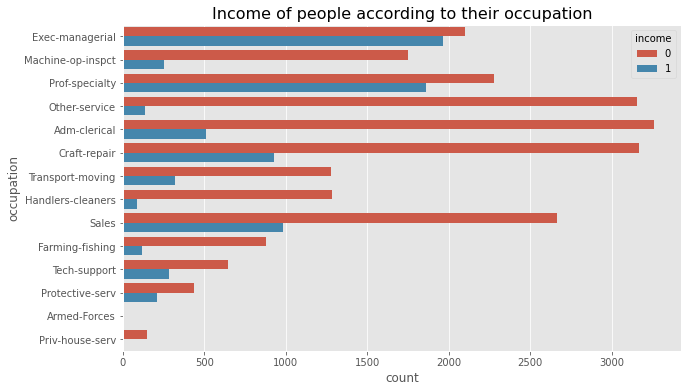

In [22]:
plt.style.use('ggplot')
plt.figure(figsize = (10,6))
plt.title("Income of people according to their occupation", fontsize = 16)
sns.countplot(y = ds['occupation'], hue = ds['income'])
plt.show()

Majority of people whose income is greater than 50K are either executive managers or they belong to any professional speciality. Now, encoding the occupation by frequency of the values in the column.

In [23]:
occupation_enc = (ds.groupby('occupation').size()) / len(ds)
print(occupation_enc)

ds['occupation_enc'] = ds['occupation'].apply(lambda x : occupation_enc[x])
ds['occupation_enc'].head(3)

occupation
Adm-clerical         0.122729
Armed-Forces         0.000293
Craft-repair         0.133440
Exec-managerial      0.132365
Farming-fishing      0.032359
Handlers-cleaners    0.044599
Machine-op-inspct    0.065174
Other-service        0.107266
Priv-house-serv      0.004851
Prof-specialty       0.134774
Protective-serv      0.021128
Sales                0.118823
Tech-support         0.030210
Transport-moving     0.051989
dtype: float64


1    0.132365
3    0.065174
4    0.134774
Name: occupation_enc, dtype: float64

In [24]:
ds.drop(['occupation'], axis = 1, inplace = True)

**'Native_country':** We are checking for the salary on people in USA and outside USA, so , **we will convert all the values where country is not USA to 'non-usa'.** This way, we can encode the values by one-hot encoding without increasing the curse of dimensionality.

In [25]:
ds['native.country'].loc[ds['native.country'] == 'United-States'] = 'usa'
ds['native.country'].loc[ds['native.country'] != 'usa'] = 'non_usa'
ds['native.country'].value_counts()

usa        27504
non_usa     3214
Name: native.country, dtype: int64

In [26]:
plt.style.use('default')

In [27]:
plt.style.use('seaborn-pastel')

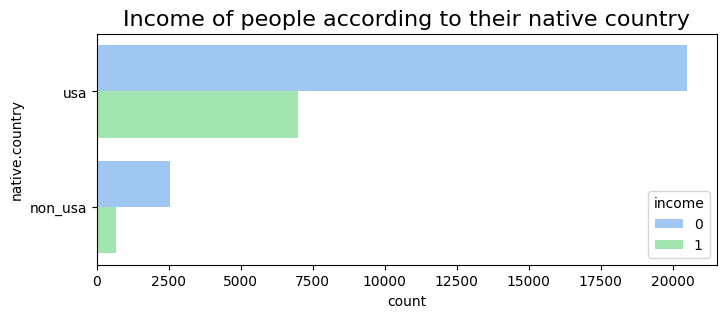

In [28]:
plt.figure(figsize = (8,3))
plt.title("Income of people according to their native country", fontsize = 16)
sns.countplot(y = ds['native.country'], hue = ds['income'])
plt.show()

**Majority of people with higher income belong to the USA**. We also have more number of people from USA then any other country combined in this dataset. Encoding this feature using one hot encoding.

In [29]:
ds['country_enc'] = ds['native.country'].map({'usa' : 1, 'non_usa' : 0})
ds.drop(['native.country'], axis = 1, inplace = True)

**'Sex':** Similarly, encoding the sex using one hot encoding.

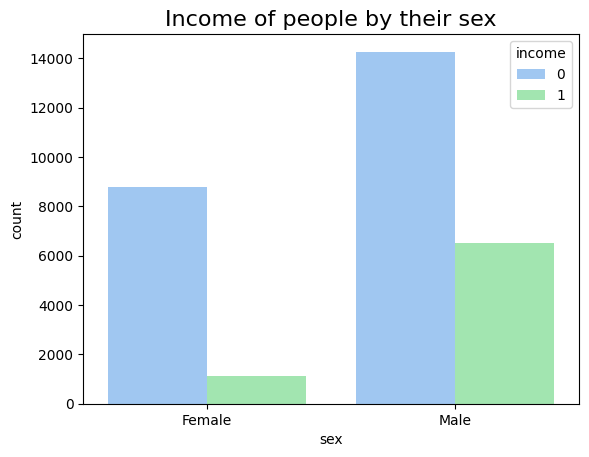

In [30]:
plt.title("Income of people by their sex", fontsize = 16)
sns.countplot(x = ds['sex'], hue = ds['income'])
plt.show()

We can see that male have more salary than female. Also in the dataset, the number of men are more than women. Encoding this feature with one hot encoding.

In [31]:
ds['sex_enc'] = ds['sex'].map({'Male' : 1, 'Female' : 0})
ds.drop(['sex'], axis = 1, inplace = True)

**'Marital_status':** Looking at the iincome of people according to their marital status.

In [32]:
plt.style.use('default')

In [33]:
plt.style.use('seaborn-talk')

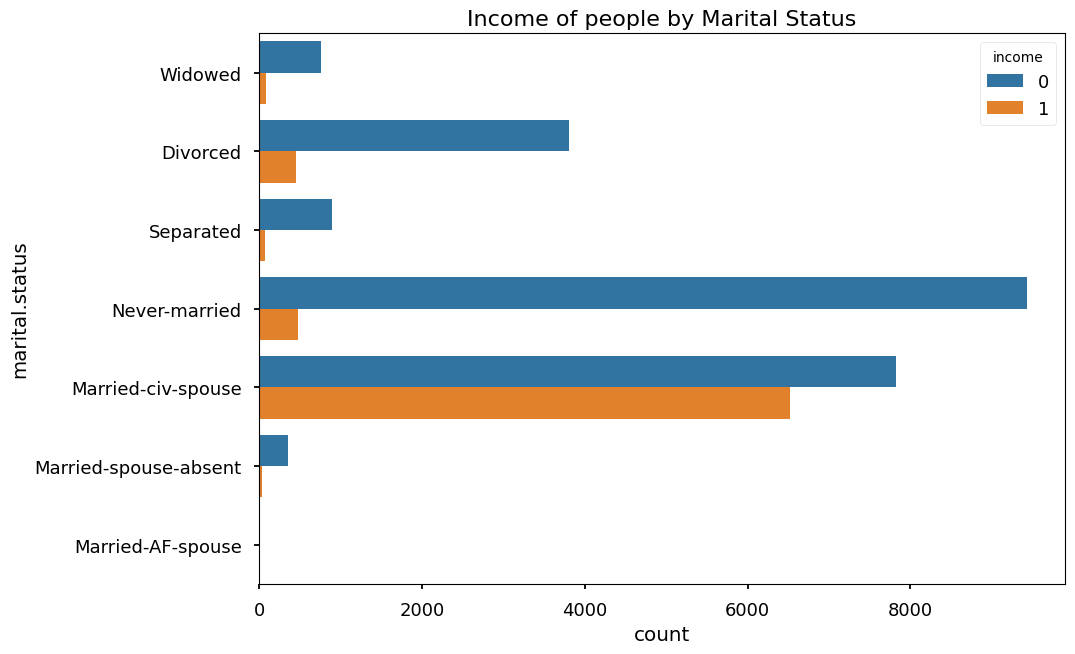

In [34]:
plt.title("Income of people by Marital Status", fontsize = 16)
sns.countplot(y = ds['marital.status'], hue = ds['income'])
plt.show()

**Married people have a higher income as compared to others.** Encoding the feature

In [35]:
marital_status_enc = (ds.groupby('marital.status').size()) / len(ds)
print(marital_status_enc)

ds['marital_status_enc'] = ds['marital.status'].apply(lambda x : marital_status_enc[x])
ds['marital_status_enc'].head(3)

marital.status
Divorced                 0.138616
Married-AF-spouse        0.000684
Married-civ-spouse       0.466795
Married-spouse-absent    0.012664
Never-married            0.322677
Separated                0.031219
Widowed                  0.027346
dtype: float64


1    0.027346
3    0.138616
4    0.031219
Name: marital_status_enc, dtype: float64

In [36]:
ds.drop(['marital.status'], axis = 1, inplace = True)

Similarly, **for 'Race' and 'Relationship'**

In [37]:
plt.style.use('bmh')

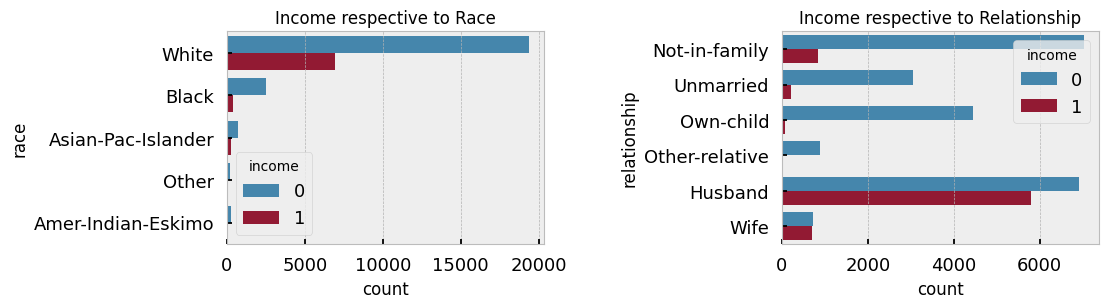

In [38]:
plt.figure(figsize = (12,4))

plt.subplot(1, 2, 1)
sns.countplot(y = ds['race'], hue = ds['income'])
plt.title("Income respective to Race", fontsize = 12)

plt.subplot(1, 2, 2)
sns.countplot(y = ds['relationship'], hue = ds['income'])
plt.title("Income respective to Relationship", fontsize = 12)

plt.tight_layout(pad = 4)
plt.show()

**White people have a higher salary as compared to other races**. Similarly, **husband in the family have a higher salary as compared to other relationship in the family.** Encoding both these columns

In [39]:
race_enc = (ds.groupby('race').size()) / len(ds)
print(race_enc,'\n')
ds['race_enc'] = ds['race'].apply(lambda x : race_enc[x])

relationship_enc = (ds.groupby('relationship').size()) / len(ds)
print(relationship_enc)
ds['relationship_enc'] = ds['relationship'].apply(lambda x : relationship_enc[x])

race
Amer-Indian-Eskimo    0.009311
Asian-Pac-Islander    0.031708
Black                 0.094700
Other                 0.008073
White                 0.856208
dtype: float64 

relationship
Husband           0.413569
Not-in-family     0.256039
Other-relative    0.029885
Own-child         0.147308
Unmarried         0.106485
Wife              0.046715
dtype: float64


In [40]:
ds.drop(['race', 'relationship'], axis = 1, inplace = True)
new_ds = ds.drop(['income'], axis = 1)
new_ds['income'] = ds['income']
new_ds

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_enc,occupation_enc,country_enc,sex_enc,marital_status_enc,race_enc,relationship_enc,income
1,82,132870,9,0,4356,18,0.69703,0.132365,1,0,0.027346,0.856208,0.256039,0
3,54,140359,4,0,3900,40,0.69703,0.065174,1,0,0.138616,0.856208,0.106485,0
4,41,264663,10,0,3900,40,0.69703,0.134774,1,0,0.031219,0.856208,0.147308,0
5,34,216864,9,0,3770,45,0.69703,0.107266,1,0,0.138616,0.856208,0.106485,0
6,38,150601,6,0,3770,40,0.69703,0.122729,1,1,0.031219,0.856208,0.106485,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,310152,10,0,0,40,0.69703,0.021128,1,1,0.322677,0.856208,0.256039,0
32557,27,257302,12,0,0,38,0.69703,0.030210,1,0,0.466795,0.856208,0.046715,0
32558,40,154374,9,0,0,40,0.69703,0.065174,1,1,0.466795,0.856208,0.413569,1
32559,58,151910,9,0,0,40,0.69703,0.122729,1,0,0.027346,0.856208,0.106485,0


## Outliers:
We check if any outliers are present in the continous attributes of the dataset. We check it both by visualisations and the zscore for the continous columns.

In [41]:
plt.style.use('default')

In [42]:
plt.style.use('ggplot')

BoxPlots of the features:


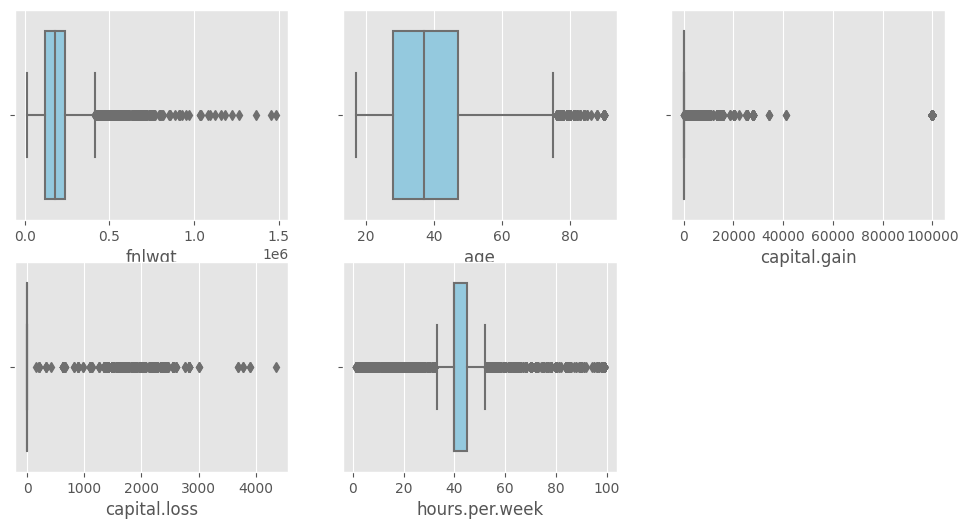

In [43]:
clist = ['fnlwgt','age','capital.gain','capital.loss','hours.per.week']
plt.figure(figsize = (12,6))
for i in range(0, len(clist)):
    plt.subplot(2,3, i+1)
    sns.boxplot(ds[clist[i]], color = 'skyblue')
print("BoxPlots of the features:")
plt.show()

**Outliers are present in the continous columns of the feature**. We will check the z-score of the features and and clip them from the data.

In [44]:
from scipy.stats import zscore
zabs = np.abs(zscore(new_ds.loc[:,'fnlwgt':'hours.per.week']))
print(np.shape(np.where(zabs >= 3)))
new_ds = new_ds[(zabs < 3).all(axis = 1)]
new_ds

(2, 2566)


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_enc,occupation_enc,country_enc,sex_enc,marital_status_enc,race_enc,relationship_enc,income
1470,62,159908,13,0,1258,38,0.064279,0.122729,1,0,0.466795,0.856208,0.046715,0
1471,72,144515,16,0,1258,40,0.064279,0.132365,1,1,0.466795,0.856208,0.413569,0
1473,66,350498,10,0,1258,20,0.697030,0.051989,1,1,0.466795,0.856208,0.413569,0
1474,33,262042,9,0,1138,40,0.064279,0.122729,1,0,0.138616,0.856208,0.147308,0
1475,29,138190,9,0,1138,40,0.697030,0.118823,1,0,0.322677,0.094700,0.106485,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,310152,10,0,0,40,0.697030,0.021128,1,1,0.322677,0.856208,0.256039,0
32557,27,257302,12,0,0,38,0.697030,0.030210,1,0,0.466795,0.856208,0.046715,0
32558,40,154374,9,0,0,40,0.697030,0.065174,1,1,0.466795,0.856208,0.413569,1
32559,58,151910,9,0,0,40,0.697030,0.122729,1,0,0.027346,0.856208,0.106485,0


WE have a total of 2566 outliers in the data. After removing the outliers, we have 28213 observations left.
## Correlation:
Checking the correlation between the features and target variable to see which of them columns are more related to target.

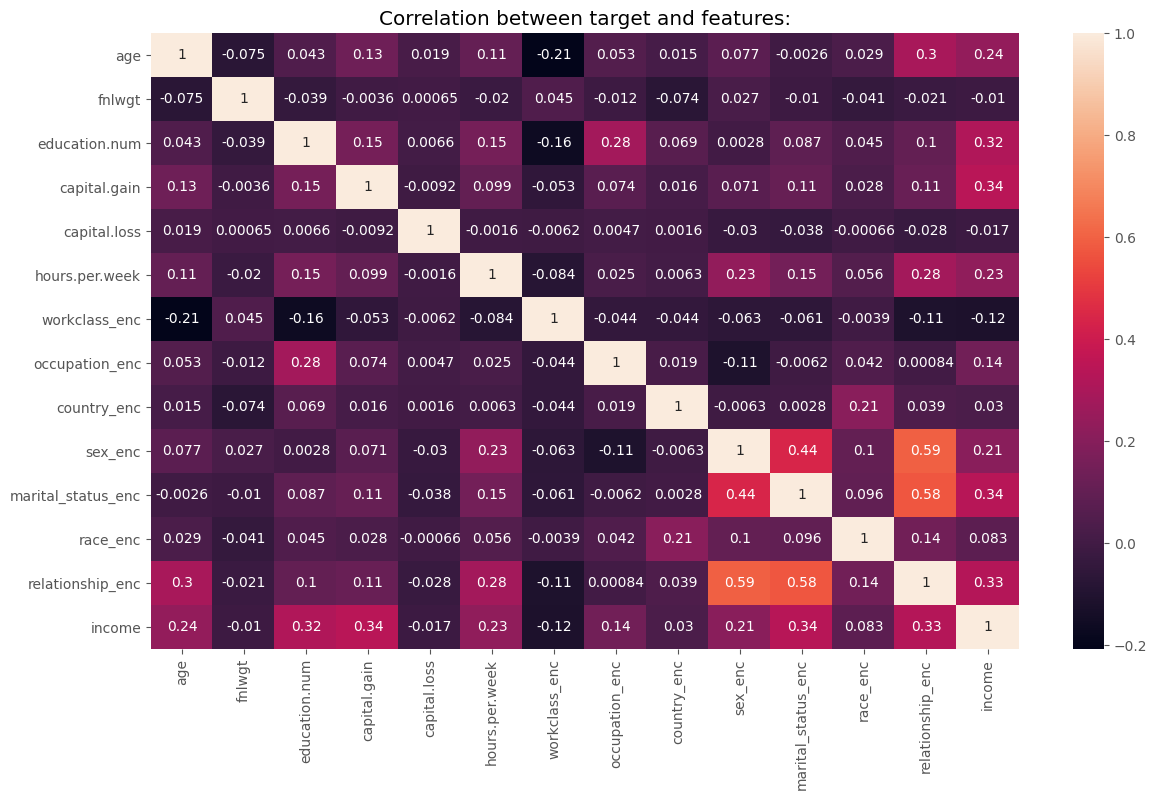

In [45]:
plt.figure(figsize = (14, 8))
plt.title("Correlation between target and features:")
sns.heatmap(new_ds.corr(), annot = True)
plt.show()

'Capital_gain', 'Education_num', 'Marital_status_enc', 'Relationship_enc' are most correlated to the Income of the observations.
## Scaling:
As we see that the values of attributes in the dataset vary largely, so it is important to scale the data. Using the Min-Max scaler in order to bring normalisation in the data.

In [46]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
new_ds.loc[:,'age':'hours.per.week'] = scale.fit_transform(new_ds.loc[:,'age':'hours.per.week'])
new_ds

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_enc,occupation_enc,country_enc,sex_enc,marital_status_enc,race_enc,relationship_enc,income
1470,0.616438,0.296903,0.769231,0.0,1.00000,0.464789,0.064279,0.122729,1,0,0.466795,0.856208,0.046715,0
1471,0.753425,0.265630,1.000000,0.0,1.00000,0.492958,0.064279,0.132365,1,1,0.466795,0.856208,0.413569,0
1473,0.671233,0.684115,0.538462,0.0,1.00000,0.211268,0.697030,0.051989,1,1,0.466795,0.856208,0.413569,0
1474,0.219178,0.504404,0.461538,0.0,0.90461,0.492958,0.064279,0.122729,1,0,0.138616,0.856208,0.147308,0
1475,0.164384,0.252780,0.461538,0.0,0.90461,0.492958,0.697030,0.118823,1,0,0.322677,0.094700,0.106485,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.068493,0.602146,0.538462,0.0,0.00000,0.492958,0.697030,0.021128,1,1,0.322677,0.856208,0.256039,0
32557,0.136986,0.494774,0.692308,0.0,0.00000,0.464789,0.697030,0.030210,1,0,0.466795,0.856208,0.046715,0
32558,0.315068,0.285660,0.461538,0.0,0.00000,0.492958,0.697030,0.065174,1,1,0.466795,0.856208,0.413569,1
32559,0.561644,0.280654,0.461538,0.0,0.00000,0.492958,0.697030,0.122729,1,0,0.027346,0.856208,0.106485,0


AS we can see from the above table that the data is now more normalised and can be used by the models for learning.
![](https://kiarofoods.com/wp-content/uploads/2019/10/line_break.png)
# Data Imbalance:
If the data is imbalanced, it can cause the overfitting and bias in the odel prediction. So it is important to check and cure the data imbalance if present. We check the target variable to see if it is balanced or not.

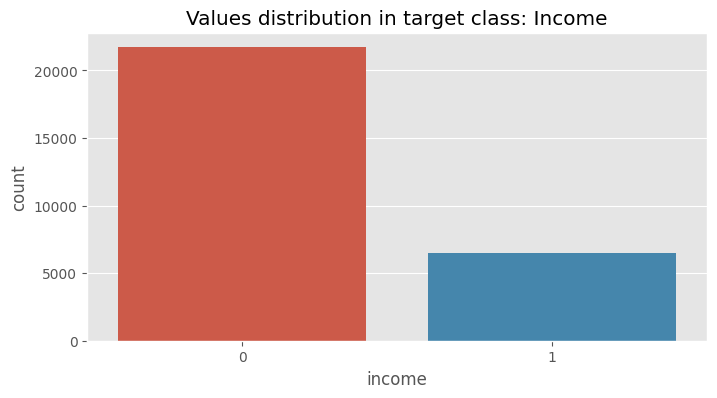

In [47]:
plt.figure(figsize = (8, 4))
plt.title("Values distribution in target class: Income")
sns.countplot(data = new_ds, x = 'income')
plt.show()

As we can see that data is imbalanced. In order **to remove the data imbalance, we use the SMOTETomek class to create synthetic values using KNN algorithm.**

In [48]:
from imblearn.combine import SMOTETomek
x = new_ds.loc[:,"age":"relationship_enc"]
y = new_ds.loc[:,"income"]
smk = SMOTETomek()
x_new, y_new = smk.fit_resample(x, y)

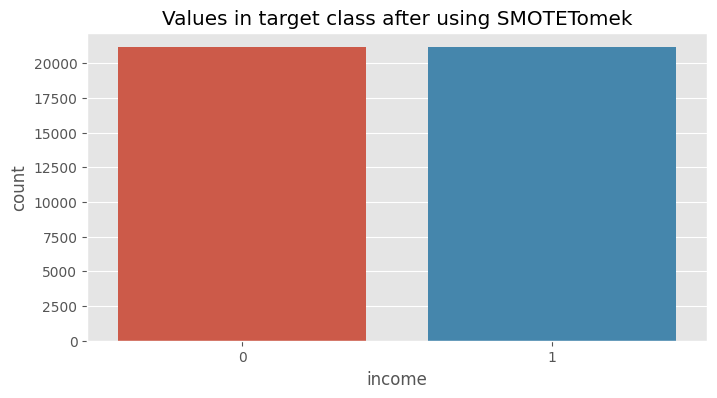

In [49]:
plt.figure(figsize = (8, 4))
plt.title("Values in target class after using SMOTETomek")
sns.countplot(x = y_new)
plt.show()

As we can see that we now have a balanced dataset, so we can model ahead with the model building part.
![](https://kiarofoods.com/wp-content/uploads/2019/10/line_break.png)
# Model Building:
Starting with the spliting of the training and testing data. For that, we check to see what is the best random state.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

max_accuracy = 0
best_rs = 0
for i in range(1, 150):
    x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size = 0.30, random_state = i)
    lg = LogisticRegression()
    lg.fit(x_train, y_train)
    pred = lg.predict(x_test)
    acc = accuracy_score(y_test, pred)
    if acc > max_accuracy: # after each iteration, acc is replace by the best possible accuracy
        max_accuracy = acc
        best_rs = i
print(f"Best Random State is {best_rs}, {max_accuracy*100}")

Best Random State is 18, 81.59223607385198


Best possible random state is 67, so using it to split the data

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size = 0.30, random_state = 67)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Model Fitting:
Fitting 7 different models to check which model gives the best accuracy.

In [52]:
# For Logistic Regression
lg = LogisticRegression()
lg.fit(x_train, y_train)
pred_lg = lg.predict(x_test)
print("Accuracy Score of Logistic Regression model is", accuracy_score(y_test, pred_lg)*100)

# For Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
pred_dtc = dtc.predict(x_test)
print("Accuracy Score of Decision Tree Classifier model is", accuracy_score(y_test, pred_dtc)*100)

# For K-Nearest Neighbour Classifier
knc = KNeighborsClassifier(n_neighbors = 5)
knc.fit(x_train, y_train)
pred_knc = knc.predict(x_test)
print("Accuracy Score of K-Nearest Neighbour Classifier model is", accuracy_score(y_test, pred_knc)*100)

# For Support Vector Classifier
svc = SVC(kernel = 'rbf')
svc.fit(x_train, y_train)
pred_svc = svc.predict(x_test)
print("Accuracy Score of Support Vector Classifier model is", accuracy_score(y_test, pred_svc)*100)

# For Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
pred_rfc = rfc.predict(x_test)
print("Accuracy Score of Random Forest model is", accuracy_score(y_test, pred_rfc)*100)

# For MultinomialNB
nb = MultinomialNB() # making the Multinomial Naive Bayes class
nb.fit(x_train, y_train) # fitting the model
pred_nb = nb.predict(x_test) # predicting the values
print("Accuracy Score of MultinomialNB model is", accuracy_score(y_test, pred_nb)*100)

# For ADA Boost Classifier
ada= AdaBoostClassifier()
ada.fit(x_train, y_train) # fitting the model
pred_ada = ada.predict(x_test) # predicting the values
print("Accuracy Score of ADA Boost model is", accuracy_score(y_test, pred_ada)*100)

Accuracy Score of Logistic Regression model is 81.18194729367208
Accuracy Score of Decision Tree Classifier model is 86.46047025406344
Accuracy Score of K-Nearest Neighbour Classifier model is 86.23954552627427
Accuracy Score of Support Vector Classifier model is 82.7836515701436
Accuracy Score of Random Forest model is 90.58702856241123
Accuracy Score of MultinomialNB model is 64.6836042291305
Accuracy Score of ADA Boost model is 84.9139971595392


Best accuracy score is given by Random Forest Classifier model. In order to avoid the bias and overfitting or underfitting, we cross validate the models and check the mean accuracy score of them.
## Cross Validation:
Cross validating the m,odels to see if they are underfitting or overfitting and to prevent bias. We will compare the mean accuracy scores of the model.

In [53]:
from sklearn.model_selection import cross_val_score

lg_scores = cross_val_score(lg, x_new, y_new, cv = 10) # cross validating the model
print(lg_scores) # accuracy scores of each cross validation cycle
print(f"Mean of accuracy scores is for Logistic Regression is {lg_scores.mean()*100}\n")

dtc_scores = cross_val_score(dtc, x_new, y_new, cv = 10)
print(dtc_scores)
print(f"Mean of accuracy scores is for Decision Tree Classifier is {dtc_scores.mean()*100}\n")

knc_scores = cross_val_score(knc, x_new, y_new, cv = 10)
print(knc_scores)
print(f"Mean of accuracy scores is for KNN Classifier is {knc_scores.mean()*100}\n")

svc_scores = cross_val_score(svc, x_new, y_new, cv = 10)
print(svc_scores)
print(f"Mean of accuracy scores is for SVC Classifier is {svc_scores.mean()*100}\n")

rfc_scores = cross_val_score(rfc, x_new, y_new, cv = 10)
print(rfc_scores)
print(f"Mean of accuracy scores is for Random Forest Classifier is {rfc_scores.mean()*100}\n")

nb_scores = cross_val_score(nb, x_new, y_new, cv = 10)
print(nb_scores)
print(f"Mean of accuracy scores is for MultinomialNB is {nb_scores.mean()*100}\n")

ada_scores = cross_val_score(ada, x_new, y_new, cv = 10)
print(ada_scores)
print(f"Mean of accuracy scores is for ADA Boost Classifier is {ada_scores.mean()*100}\n")

[0.74745562 0.78911243 0.79857988 0.80804734 0.81017751 0.81278107
 0.82054924 0.8186553  0.82410038 0.81060606]
Mean of accuracy scores is for Logistic Regression is 80.40064831002331

[0.67029586 0.74130178 0.74579882 0.90414201 0.91810651 0.90982249
 0.91548295 0.90932765 0.90980114 0.91098485]
Mean of accuracy scores is for Decision Tree Classifier is 85.35064046530391

[0.82721893 0.85112426 0.85633136 0.87100592 0.87266272 0.87857988
 0.88494318 0.87571023 0.88517992 0.87689394]
Mean of accuracy scores is for KNN Classifier is 86.79650349650349

[0.78224852 0.82272189 0.82035503 0.8243787  0.82934911 0.8364497
 0.84161932 0.83285985 0.83806818 0.8359375 ]
Mean of accuracy scores is for SVC Classifier is 82.6398780706473

[0.70911243 0.80331361 0.81467456 0.93680473 0.94674556 0.93609467
 0.9547822  0.94389205 0.95004735 0.94389205]
Mean of accuracy scores is for Random Forest Classifier is 89.39359198493813

[0.63029586 0.58721893 0.60284024 0.66366864 0.65680473 0.66792899
 0.65

In [54]:
# Checking for difference between accuracy and mean accuracies.
lis3 = ['Logistic Regression','Decision Tree Classifier','KNeighbors Classifier','SVC', 'Random Forest Classifier', 
        'MultinomialNB', 'ADA Boost Classifier']

lis1 = [accuracy_score(y_test, pred_lg)*100, accuracy_score(y_test, pred_dtc)*100, accuracy_score(y_test, pred_knc)*100, 
        accuracy_score(y_test, pred_svc)*100, accuracy_score(y_test, pred_rfc)*100, accuracy_score(y_test, pred_nb)*100,
        accuracy_score(y_test, pred_ada)*100]

lis2 = [lg_scores.mean()*100, dtc_scores.mean()*100, knc_scores.mean()*100, svc_scores.mean()*100, rfc_scores.mean()*100, 
        nb_scores.mean()*100, ada_scores.mean()*100]

for i in range(0, 7):
    dif = (lis1[i]) - (lis2[i])
    print(lis3[i], dif)

Logistic Regression 0.7812989836487674
Decision Tree Classifier 1.1098297887595265
KNeighbors Classifier -0.5569579702292202
SVC 0.14377349949630513
Random Forest Classifier 1.1934365774731077
MultinomialNB 0.20635223433042427
ADA Boost Classifier 1.2252901934283926


**Random forest classifier is the best model with highest cross validation mean score and accuracy score**. We will use it for the model building.
## Hyperparameter Tuning:
Tuning the parameters of the Random Forest in order to obtain the best possible parameters for model building.

In [55]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()
param = dict()
param['criterion'] = ['gini', 'entropy']
param['n_estimators'] = [1, 2, 4, 8, 10, 16, 32, 64, 100, 200]
param['min_samples_split'] = [1,2,5,8,10,15,20,25,50,55,60,80,100]


gs = GridSearchCV(estimator = rfc, param_grid = param, scoring='f1', cv = 5, n_jobs = 3)
gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9065754586536448
{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 200}


After the hyperparameter tuning, **the best parameters for Random Forest Classifier are 'crietrion' = 'entropy', 'min_samples_split' = 2, 'n_estimators' = 100**. We build the model using these parameters.

In [56]:
rfc = RandomForestClassifier(criterion = 'entropy', min_samples_split = 2, n_estimators = 100)
rfc.fit(x_train, y_train)
print(rfc.score(x_train, y_train))
pred_rfc = rfc.predict(x_test)

1.0


![](https://kiarofoods.com/wp-content/uploads/2019/10/line_break.png)
# Model Evaluation:
We have build the model after the cross validation and hyper parameter tuning. It is now time to evaluate the model using the classification report, confusion matrix and ROC curve.

Accuracy Score of RFC model is 90.69749092630582
Confusion matrix for RFC Model is
[[5696  638]
 [ 541 5799]]
Classification Report of the RFC Model is
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6334
           1       0.90      0.91      0.91      6340

    accuracy                           0.91     12674
   macro avg       0.91      0.91      0.91     12674
weighted avg       0.91      0.91      0.91     12674



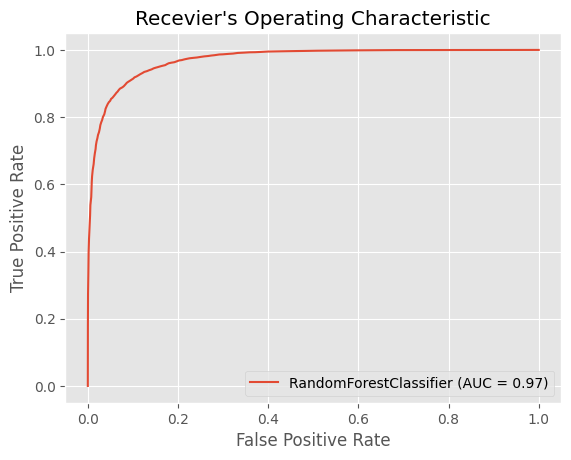

In [57]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report

print("Accuracy Score of RFC model is", accuracy_score(y_test, pred_rfc)*100)
print("Confusion matrix for RFC Model is")
print(confusion_matrix(y_test, pred_rfc))
print("Classification Report of the RFC Model is")
print(classification_report(y_test, pred_rfc))

plot_roc_curve(rfc, x_test, y_test) # arg. are model name, feature testing data, label testing data.
plt.title("Recevier's Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

After the model evaluation , we get the **precision and recall for both the target variable as 0.92 and 0.91**. The **f1- score of the model is 0.92**. The ROC curve gave us **the AUC score which is 0.98**. Model evaluation gives the results that ***the prediction is very accurate.***
![](https://miro.medium.com/max/2400/1*IH10jlQEJ7GW1_oq8s7WPw.png)
# Serialisation:
Now we save the Random Forest Classifier Model as an object using joblib.

In [58]:
import joblib
joblib.dump(rfc, 'Census Income Prediction.obj') # saving the model as an object

['Census Income Prediction.obj']

## Fairness

In [50]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [51]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [52]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [53]:
##train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
x_new['income'] = y_new
x_new.head()
#features = ["Pclass", "Sex", "SibSp", "Parch", "Survived"]
#X = pd.get_dummies(train_data[features])

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_enc,occupation_enc,country_enc,sex_enc,marital_status_enc,race_enc,relationship_enc,income
0,0.616438,0.296903,0.769231,0.0,1.00000,0.464789,0.064279,0.122729,1,0,0.466795,0.856208,0.046715,0
1,0.753425,0.265630,1.000000,0.0,1.00000,0.492958,0.064279,0.132365,1,1,0.466795,0.856208,0.413569,0
2,0.671233,0.684115,0.538462,0.0,1.00000,0.211268,0.697030,0.051989,1,1,0.466795,0.856208,0.413569,0
3,0.219178,0.504404,0.461538,0.0,0.90461,0.492958,0.064279,0.122729,1,0,0.138616,0.856208,0.147308,0
4,0.164384,0.252780,0.461538,0.0,0.90461,0.492958,0.697030,0.118823,1,0,0.322677,0.094700,0.106485,0


In [54]:
privileged_groups = [{'sex_enc': 1}]
unprivileged_groups = [{'sex_enc': 0}]
dataset_orig = StandardDataset(x_new,
                                  label_name='income',
                                  protected_attribute_names=['sex_enc'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])

In [55]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.ensemble import AdaBoostClassifier
import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100

model = AdaBoostClassifier(n_estimators = 1)

mdl = model.fit(X_train, y_train)
with open('../../Results/AdaBoost/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/AdaBoost/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/AdaBoost/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [56]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = AdaBoostClassifier(n_estimators= i)
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [57]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
print(final_result)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/AdaBoost/' + nb_fname + '.csv')
final_result

           0         1         2         3         4
0  -0.489667 -0.274678  0.333797  0.326917  0.114503
1  -0.489667 -0.274678  0.333797  0.326917  0.114503
2  -0.476012 -0.207990  0.300087  0.356299  0.098364
3  -0.463112 -0.223016  0.285508  0.343126  0.103231
4  -0.328021 -0.173282  0.167031  0.363957  0.178846
..       ...       ...       ...       ...       ...
95 -0.382102 -0.147623  0.170351  0.382188  0.090602
96 -0.385429 -0.152675  0.173799  0.378979  0.089444
97 -0.379574 -0.143573  0.166849  0.384339  0.090467
98 -0.383776 -0.152230  0.172284  0.379699  0.089998
99 -0.380557 -0.146509  0.168575  0.382854  0.090855

[100 rows x 5 columns]


,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
accuracy,0.861107,0.770929,0.770929,0.785039,0.799622,0.789374,0.827053,0.829261,0.820905,0.825792,...,0.859924,0.859924,0.860318,0.861343,0.861659,0.860634,0.861580,0.861580,0.861659,0.861107
f1,0.863029,0.790875,0.790875,0.806527,0.814480,0.772866,0.839338,0.839031,0.819108,0.830235,...,0.862301,0.862195,0.862614,0.863760,0.863710,0.862754,0.863855,0.863516,0.863732,0.863029
statistical_parity_difference,-0.380557,-0.489667,-0.489667,-0.476012,-0.463112,-0.328021,-0.412997,-0.424547,-0.385264,-0.381616,...,-0.385786,-0.381909,-0.385429,-0.387233,-0.383160,-0.382102,-0.385429,-0.379574,-0.383776,-0.380557
equal_opportunity_difference,-0.146509,-0.274678,-0.274678,-0.207990,-0.223016,-0.173282,-0.135784,-0.184808,-0.210735,-0.152325,...,-0.150149,-0.146768,-0.151190,-0.153603,-0.150818,-0.147623,-0.152675,-0.143573,-0.152230,-0.146509
average_abs_odds_difference,0.168575,0.333797,0.333797,0.300087,0.285508,0.167031,0.210132,0.229861,0.207366,0.188492,...,0.174345,0.170350,0.174090,0.175629,0.171449,0.170351,0.173799,0.166849,0.172284,0.168575
disparate_impact,-0.960102,-1.118050,-1.118050,-1.031986,-1.069658,-1.010719,-0.917348,-0.990932,-1.045965,-0.933028,...,-0.970081,-0.958494,-0.970275,-0.973950,-0.966613,-0.961843,-0.970275,-0.956230,-0.968377,-0.960102
theil_index,0.090855,0.114503,0.114503,0.098364,0.103231,0.178846,0.087191,0.092586,0.128684,0.109787,...,0.090349,0.090670,0.090305,0.089190,0.090062,0.090602,0.089444,0.090467,0.089998,0.090855
